In [1]:
import pandas as pd
import numpy as np
from ape import chain, Contract, networks

In [2]:
networks.parse_network_choice('ethereum:mainnet:alchemy').__enter__()

<alchemy chain_id=1>

In [3]:
mim_curve_pool = Contract("0x5a6A4D54456819380173272A5E8E9B9904BdF41B")
mim_curve_pool

<Vyper_contract 0x5a6A4D54456819380173272A5E8E9B9904BdF41B>

In [4]:
base_curve_pool = Contract("0xbEbc44782C7dB0a1A60Cb6fe97d0b483032FF1C7")
base_curve_pool

<Vyper_contract 0xbEbc44782C7dB0a1A60Cb6fe97d0b483032FF1C7>

In [5]:
# A = 2000
A = mim_curve_pool.A()
A

2000

In [6]:
PRECISION = 10**18

In [7]:
# get the balances for mim and 3crv
# mim is coin0, 3crv is coin1
coin0_addr = mim_curve_pool.coins(0)
coin1_addr = mim_curve_pool.coins(1)

print(f"coin 0: {coin0_addr}")
print(f"coin 1: {coin1_addr}")

coin 0: 0x99D8a9C45b2ecA8864373A26D1459e3Dff1e17F3
coin 1: 0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490


In [8]:
mim = Contract(coin0_addr)
mim

<MagicInternetMoneyV1 0x99D8a9C45b2ecA8864373A26D1459e3Dff1e17F3>

In [9]:
crv3 = Contract(coin1_addr)
crv3

<3Crv 0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490>

In [10]:
bal_mim = mim_curve_pool.balances(0) / (10 ** mim.decimals()) # adjust for decimals
bal_3crv = mim_curve_pool.balances(1) / (10 ** crv3.decimals())

print(f"balance 0 (MIM): {bal_mim}")
print(f"balance 1 (3Crv): {bal_3crv}")

balance 0 (MIM): 54802863.031657666
balance 1 (3Crv): 44819574.18899209


In [11]:
# D calc for two coin case
def _d(x0, x1):
    # Cardano: t**3 + p*t + q = 0
    # SEE: https://en.wikipedia.org/wiki/Cubic_equation#Derivation_of_the_roots
    q = - 16 * A * x0 * x1 * (x0 + x1)
    p = 4 * x0 * x1 * (4 * A - 1)
    delta = ((q/2.0)**2 + (p/3.0)**3)**(1/2)
    
    u1 = (-q/2.0 + delta)**(1/3)
    u2 = (q/2.0 + delta)**(1/3)

    return u1 - u2

In [12]:
D = _d(bal_mim, bal_3crv)
D

99622310.92939663

In [13]:
# some stableswap fns for two coin case
def B(x):
    return D * (1 - 4*A) * x + 4*A*(x**2)

def E(x):
    return 4*A*x

def y(x):
    return (-B(x) + np.sqrt(B(x)**2 + (D**3) * E(x))) / (2 * E(x))

def p(x):
    return (y(x) / x) * ((D**3) + 16 * A * (x**2) * (y(x))) / ((D**3) + 16 * A * (x) * (y(x)**2))

In [14]:
# in line with current balance of 3crv in pool
print('y(bal_mim):', y(bal_mim))
print('y(bal_mim) / bal_3crv - 1:', y(bal_mim) / bal_3crv - 1)

y(bal_mim): 44819574.18899187
y(bal_mim) / bal_3crv - 1: -4.9960036108132044e-15


In [15]:
# plot price for mim balances
xs = np.linspace(1000000, D, 100000)
prices = [ p(x) for x in xs ]
df = pd.DataFrame(data={'x': xs, 'price': prices})

<AxesSubplot: xlabel='x'>

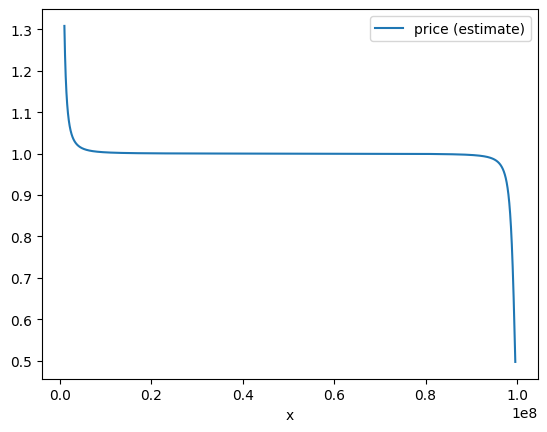

In [16]:
df.plot(x='x', y='price', label='price (estimate)')

<AxesSubplot: xlabel='x'>

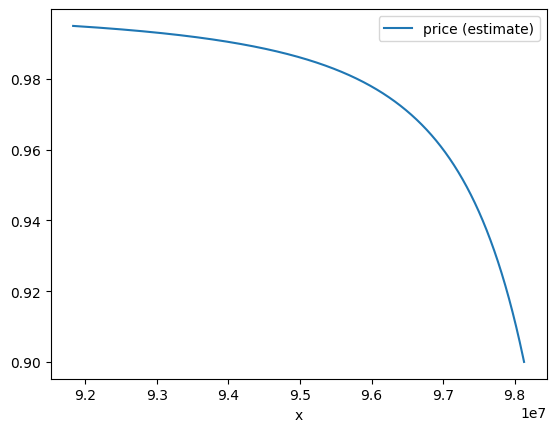

In [17]:
# zoom in near larger mim balance values for transition away from price of 1
df[(df['price'] < 0.995) & (df['price'] > 0.9)].plot(x='x', y='price', label='price (estimate)')

In [18]:
# get the inverse from linspace eval
df[abs(df['price'] - 0.9759) < 0.00005]

,x,price
96487,9.615866e+07,0.975947
96488,9.615965e+07,0.975934
96489,9.616063e+07,0.975921
96490,9.616162e+07,0.975908
96491,9.616261e+07,0.975896
96492,9.616359e+07,0.975883
96493,9.616458e+07,0.975870
96494,9.616556e+07,0.975857


In [19]:
# dx is estimated amount of MIM need to sell into pool to push price below strike
dx = df[abs(df['price'] - 0.9759) < 0.00005].iloc[-1].x - bal_mim
dx

41362701.33219795